In [9]:
#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
#!unrar x UCF50.rar /content/drive/MyDrive/Colab_Notebooks

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import moviepy.editor as mp
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [13]:
#Loading And Pre-Processing The Data
def LoadData(path, clases):
    path = path + '/' + clases
    videos = os.listdir(path)
    lst = []
    for i in range(len(videos)):
        video = mp.VideoFileClip(path + '/' + videos[i])
        video = video.resize((64, 64))
        video = np.array(list(video.iter_frames()))
        frms = int(video.shape[0]/20)
        frms = np.arange(0, 20*frms, frms)
        video = video[frms]
        lst = lst + [video]
    lst = np.array(lst)
    return lst

#Lebeling The Data For Supervised Learning
def LebelData(path):
    clases = os.listdir(path)
    code = np.arange(0,len(clases),1)
    code = to_categorical(code)
    _input_ = LoadData(path, clases[0])
    _output_ = np.tile(code[0], (_input_.shape[0], 1))
    for i in range(1,len(clases)):
        input = LoadData(path, clases[i])
        _input_ = np.concatenate((_input_, input))
        output = np.tile(code[i], (input.shape[0], 1))
        _output_ = np.concatenate((_output_, output))
    _input_ = _input_/255
    return _input_, _output_

path = '/content/drive/MyDrive/Colab_Notebooks/UCF50'
inp, opt = LebelData(path)
X_train, X_test, Y_train, Y_test = train_test_split(inp, opt, test_size=0.2, random_state=42)

In [14]:
#CNN-LSTM Model
def DeepModel():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (20, 64, 64, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32))
    model.add(Dense(10, activation = 'softmax'))
    model.summary()
    return model

deepmodel = DeepModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 32)     0

In [15]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
deepmodel.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
history = deepmodel.fit(x = X_train, y = Y_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stop])
deepmodel.save('/content/drive/MyDrive/Colab_Notebooks/deepmodel.h5')

Epoch 1/70
221/221 [==============================] - 23s 21ms/step - loss: 2.1999 - accuracy: 0.1540 - val_loss: 1.8248 - val_accuracy: 0.3167
Epoch 2/70
221/221 [==============================] - 3s 13ms/step - loss: 1.7558 - accuracy: 0.3420 - val_loss: 1.5165 - val_accuracy: 0.4027
Epoch 3/70
221/221 [==============================] - 2s 11ms/step - loss: 1.4048 - accuracy: 0.4757 - val_loss: 1.3431 - val_accuracy: 0.4661
Epoch 4/70
221/221 [==============================] - 2s 11ms/step - loss: 1.1943 - accuracy: 0.5572 - val_loss: 1.0439 - val_accuracy: 0.6109
Epoch 5/70
221/221 [==============================] - 2s 11ms/step - loss: 0.9944 - accuracy: 0.6014 - val_loss: 0.9253 - val_accuracy: 0.6244
Epoch 6/70
221/221 [==============================] - 3s 12ms/step - loss: 0.9556 - accuracy: 0.6625 - val_loss: 0.8735 - val_accuracy: 0.6561
Epoch 7/70
221/221 [==============================] - 3s 14ms/step - loss: 0.8384 - accuracy: 0.6965 - val_loss: 0.7847 - val_accuracy: 0.728

In [16]:
deepmodel.evaluate(X_test, Y_test)

9/9 [==============================] - 1s 41ms/step - loss: 0.3221 - accuracy: 0.9275


[0.32207778096199036, 0.9275362491607666]

In [17]:
import matplotlib.pyplot as plt

def plot_metric(history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = history.history[metric_name_1]
    metric_value_2 = history.history[metric_name_2]
    epochs = range(len(metric_value_1))
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()


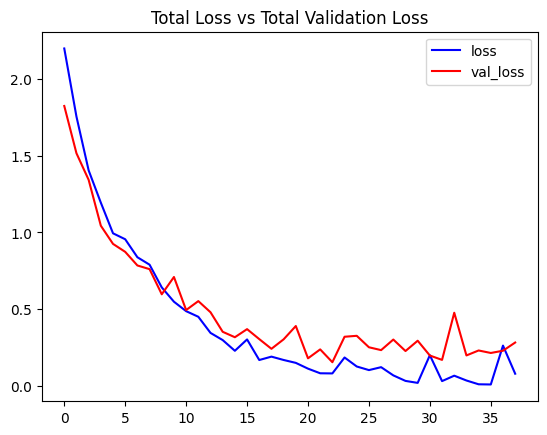

In [18]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

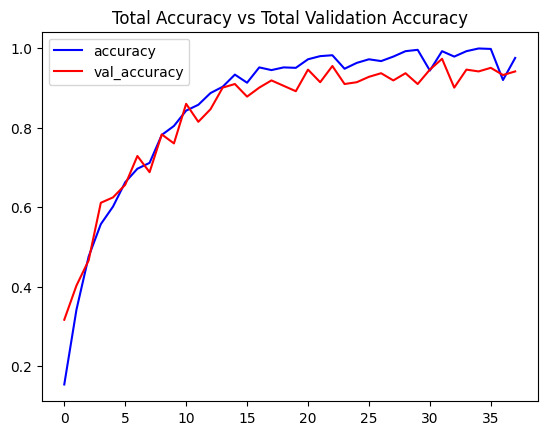

In [19]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')